In [1]:
%matplotlib inline


用基于注意力机制的seq2seq神经网络进行翻译
*************************************************************
**作者**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

这个教程主要讲解用一个神经网络将法语翻译成英语.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... 取得不同阶段的成功.

这是通过`seq2seq网络 <http://arxiv.org/abs/1409.3215>`__实现的简单却强大的想法,
通过两个递归神经网络一起工作实现将一个序列转换为另一个.一个编码器网络将输入序列压
缩成向量,解码器网络将该矢量展开为新的序列.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:
   
为了改进这个模型,我们将使用一种`注意力机制<https://arxiv.org/abs/1409.0473>`__,
它可以让解码器学习将注意力集中在输入序列的特定范围上.

**推荐阅读:**

我们假设你至少已经安装了PyTorch,了解Python,并且了解张量:

-  http://pytorch.org/ PyTorch安装说明
-  :doc:`/beginner/deep_learning_60min_blitz` 开始使用PyTorch
-  :doc:`/beginner/pytorch_with_examples` 进行广泛而深入的了解
-  :doc:`/beginner/former_torchies_tutorial` 如果你是前Lua Torch用户


这些内容也有利于了解seq2seq网络和其工作机制:

-  `用RNN编码器 - 解码器来学习用于统计机器翻译的短语表示 <http://arxiv.org/abs/1406.1078>`__
-  `用神经网络进行seq2seq学习 <http://arxiv.org/abs/1409.3215>`__
-  `神经网络机器翻译联合学习对齐和翻译 <https://arxiv.org/abs/1409.0473>`__
-  `神经会话模型 <http://arxiv.org/abs/1506.05869>`__

你还可以找到以前的教程关于Character-Level RNN名称分类
:doc:`/intermediate/char_rnn_classification_tutorial`
和生成名称 :doc:`/intermediate/char_rnn_generation_tutorial`
这些概念与编码器和解码器模型非常相似.

更多内容请阅读介绍这些主题的论文:

-  `用RNN编码器 - 解码器来学习用于统计机器翻译的短语表示 <http://arxiv.org/abs/1406.1078>`__
-  `用神经网络进行seq2seq学习 <http://arxiv.org/abs/1409.3215>`__
-  `神经网络机器翻译联合学习对齐和翻译 <https://arxiv.org/abs/1409.0473>`__
-  `神经会话模型 <http://arxiv.org/abs/1506.05869>`__


**要求**



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

加载数据文件
==================

这个项目的数据是一组数以千计的英语到法语的翻译对.

`这个问题在 Open Data Stack Exchange上
 <http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
指导我们使用开放的翻译网站 http://tatoeba.org/ 可下载地址为 http://tatoeba.org/eng/downloads - 更好的是,
有人做了额外的工作,切分语言对到单个文本文件中: http://www.manythings.org/anki/

英文到法文对太大而不能包含在repo中,因此开始前请下载
 ``data/eng-fra.txt``. 该文件是一个制表符分隔的翻译对列表: :

::

    I am cold.    Je suis froid.

.. Note::
   下载数据文件在
   `这里 <https://download.pytorch.org/tutorial/data.zip>`_
   并解压到正确的路径.



与character-level RNN教程中使用的字符编码类似,我们将用语言中的每个单词
作为独热向量,或者除了单个单词之外(在单词的索引处)的大的零向量. 相较于可能
存在于一种语言中仅有十个字符相比,多数都是有大量的字,因此编码向量很大. 
然而,我们会欺骗性的做一些数据修剪,保证每种语言只使用几千字.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:http://pytorch.apachecn.org/cn/tutorials/_images/word-encoding.png





我们需要每个单词对应唯一的索引作为稍后的网络输入和目标.为了追踪这些索引我们使用一个帮助类
 ``Lang`` 类中有 词 → 索引 (``word2index``) 和 索引 → 词
(``index2word``) 的字典, 以及每个词``word2count`` 用来替换稀疏词汇.




In [3]:
SOS_token = 0
EOS_token = 1

#建立词袋
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}#word:index
        self.word2count = {}#word:count
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS，#从2开始编号

    #分割句子里面的单词
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    #将单词添加在列表中
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words #Count SOS and EOS，#从2开始编号#word:index
            self.word2count[word] = 1 #word:count
            self.index2word[self.n_words] = word#index:word
            self.n_words += 1#统计不同单词的个数
        else:
            self.word2count[word] += 1#统计单词出现的次数

这些文件全部采用Unicode编码,为了简化我们将Unicode字符转换为ASCII,
使所有内容小写,并修剪大部分标点符号.



In [4]:
# 感谢您将Unicode字符串转换为纯ASCII
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小写,修剪和删除非字母字符
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
#re.sub用于替换字符串中的匹配项。下面一个例子将字符串中的空格 ’ ’ 替换成 ‘-’ : 
text = "JGood is a handsome boy, he is cool, clever, and so on…" 
print(re.sub(r'\s+','-', text))

JGood-is-a-handsome-boy,-he-is-cool,-clever,-and-so-on…


要读取数据文件,我们将把文件分成行,然后将行成对分开.
这些文件都是英文→其他语言,所以如果我们想从其他语言翻译→英文,我们添加了
翻转标志 ``reverse``来翻转词语对.




In [6]:
#读取文件中的翻译对，reverse=True时，input_lang为法文句子，output_lang为英文句子，pairs为法文句子-->英文句子的翻译对
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 读取文件并按行分开
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 将每一行分成两列并进行标准化
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]#\t是水平制表符

    # 翻转对,Lang实例化
    if reverse:#其他语言-->英语
        pairs = [list(reversed(p)) for p in pairs]#反转字符串
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:#英语-->其他语言
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
#reversed反转字符串用法：
seqString = ("'Runoob1","'Runoob2")
print(len(seqString))
print(list(reversed(seqString)))
Lang('eng')

2
["'Runoob2", "'Runoob1"]


由于有很多例句,我们希望快速训练,我们会将数据集裁剪为相对简短的句子. 
这里的单词的最大长度是10词(包括结束标点符号),我们正在过滤到翻译
成"I am"或"He is"等形式的句子.(考虑到先前替换了撇号).




In [8]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

#Python 通常是一行写完一条语句，但如果语句很长，我们可以使用反斜杠(\)来实现多行语句
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)#要选择英语状态下包含eng_prefixes其中一个的句子


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
#startswith() 方法用于检查字符串是否是以指定子字符串开头，如果是则返回 True，否则返回 False。
#如果参数 beg 和 end 指定值，则在指定范围内检查。
str = "this is string example....wow!!!"
str1 = "is string example....wow!!!"

print(str.startswith( ('this','is') ))
print(str1.startswith( ('this','is') ))
print(str.startswith( 'is'))
print(str.startswith( 'is', 2, 4 ))
print(str.startswith( 'this', 2, 4 ));

True
True
False
True
False


完整的准备数据的过程:

-  加载文本文件切分成行,并切分成单词对:
-  文本归一化, 按照长度和内容过滤
-  从成对的句子中制作单词列表




In [10]:
def prepareData(lang1, lang2, reverse=False):
    #input_lang, output_lang为利用Lang这个类创建的对象拥有各种属性
    #input_lang.name_readLangs: {} output_lang.name_readLangs: eng
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
#     print('input_lang.word2index_readLangs:',input_lang.word2index, 'output_lang.name_readLangs:',output_lang.name, 
#           'pairs_readLangs:',random.choice(pairs))
    print("Read %s sentence pairs" % len(pairs))#打印全部句子的对数
    #我们希望快速训练,我们会将数据集裁剪为相对简短的句子
    pairs = filterPairs(pairs)#过滤掉不符合要求的句子对
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    #分别制作输入与输出的词袋：单词+索引+词频+不同单词的个数
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

#input_lang和output_lang包含了类Lang里面的各种属性, pairs:fra-->eng
#lang1:eng, lang2:fra, reverse:True
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


In [11]:
print(random.choice(pairs))
#print(len(input_lang.word2index),input_lang.word2index.items())

['elles mentent toutes .', 'they re all lying .']


In [12]:
#随机挑选一个翻译对进行测试
part_random=random.choice(pairs)
print('part_random:',part_random)

part_random: ['je suis mariee .', 'i am married .']


Seq2Seq模型
=================

递归神经网络(RNN),是一个按照一个序列进行操作的网路,并
将其自己的输出用作后续步骤的输入.

一个 `序列到序列网络 <http://arxiv.org/abs/1409.3215>`__, 或
seq2seq 网络, 或 `编码解码器网络 <https://arxiv.org/pdf/1406.1078v3.pdf>`__, 
是由两个称为编码器和解码器的RNN组成的模型. 编码器读取输入序列并输出单个向量,
解码器读取该向量以产生输出序列.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:http://pytorch.apachecn.org/cn/tutorials/_images/seq2seq.png

与单个RNN的序列预测不同,每个输入对应一个输出,
seq2seq模型将我们从序列长度和顺序中解放出来,
这使得它成为两种语言之间翻译的理想选择.

考虑这句话 "Je ne suis pas le chat noir" → "I am not the
black cat".  输入句子中的大部分单词在输出句子中有直接翻译,
但顺序略有不同,例如: "chat noir" 和 "black cat". 由于 
"ne/pas"结构, 其中另一个单词在输入的句子中. 
直接从输入词的序列中直接生成正确的翻译是很困难的.

使用seq2seq模型,编码器会创建一个单独的向量,
在理想情况下,它将输入序列的"含义"编码为单个向量 - 句子的N维空间中的一个点.




编码器
-----------

seq2seq网络的编码器是一个RNN,它为输入句子中的每个单词输出一些值.
对于每个输入字,编码器输出一个向量和一个隐藏状态,并将隐藏状态用于下一个输入字.

.. figure:: http://pytorch.apachecn.org/cn/tutorials/_images/encoder-network.png
   :alt:





In [13]:
#将每个单词进行编码为一个有256个属性值的向量
#input是单词所在的索引位置
#output是单词经过编码之后的编码向量
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #返回input_size对应索引下的样本
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)#相当于RNN

    def forward(self, input, hidden):
        #这是一个矩阵类，里面初始化了一个随机矩阵，矩阵的长是字典的大小，
        #宽是用来表示字典中每个元素的属性向量，向量的维度根据你想要表示的元素的复杂度而定。
        #而对于一个词，我们自己去想它的属性不是很困难吗，所以这个时候就可以交给神经网络了，
        #我们只需要定义我们想要的维度，比如100，然后通过神经网络去学习它的每一个属性的大小，
        #而我们并不用关心到底这个属性代表着什么，我们只需要知道词向量的夹角越小，表示他们之间的语义更加接近
        embedded = self.embedding(input).view(1, 1, -1)#相当于将每个单词返回一个256个属性值
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


In [14]:
#测试EncoderRNN的功能
hidden_size = 256
print(input_lang.n_words)#表示用于输入需要翻译句子的单词个数
encoder1_test = EncoderRNN(input_lang.n_words, hidden_size)
print(encoder1_test)

4489
EncoderRNN(
  (embedding): Embedding(4489, 256)
  (gru): GRU(256, 256)
)


In [15]:
#返回input对应索引下的样本
# an Embedding module containing 10 tensors of size 3
embedding = nn.Embedding(10, 4)
# a batch of 2 samples of 4 indices each
print(embedding)
print(type(embedding))
input = Variable(torch.LongTensor([[1,2,4,5],[4,3,2,9]]))
print('embedding(input):\n',embedding(input))

#view用法
a=torch.tensor([[1,2,3,4],[2,3,4,5]])
print('a.view(-1):',a.view(-1))
print('a.view(-1,2):\n',a.view(-1,2))
print('a.view(4,-1):\n',a.view(4,-1))

#nn.GRU的用法
rnn1 = nn.GRU(10, 20, 2)
print(rnn1)
input = Variable(torch.randn(5, 3, 10))
h0 = Variable(torch.randn(2, 3, 20))
output, hn = rnn1(input, h0)
print('output:',output.size(),' hn:', hn.size())

Embedding(10, 4)
<class 'torch.nn.modules.sparse.Embedding'>
embedding(input):
 tensor([[[-0.8626, -0.4190,  1.1497,  1.1777],
         [-0.0144,  1.3691,  1.9146,  1.3023],
         [ 2.1524,  1.4383,  0.8639, -1.0514],
         [ 1.4872, -0.2425,  0.6671,  2.9068]],

        [[ 2.1524,  1.4383,  0.8639, -1.0514],
         [-1.1365,  0.5926, -1.3604,  1.3536],
         [-0.0144,  1.3691,  1.9146,  1.3023],
         [ 0.5676, -0.3520,  0.6516, -0.3649]]], grad_fn=<EmbeddingBackward>)
a.view(-1): tensor([1, 2, 3, 4, 2, 3, 4, 5])
a.view(-1,2):
 tensor([[1, 2],
        [3, 4],
        [2, 3],
        [4, 5]])
a.view(4,-1):
 tensor([[1, 2],
        [3, 4],
        [2, 3],
        [4, 5]])
GRU(10, 20, num_layers=2)
output: torch.Size([5, 3, 20])  hn: torch.Size([2, 3, 20])


解码器
-----------

解码器是另一个RNN,它接收编码器输出向量并输出一个单词序列来创建翻译.




简单的解码器
^^^^^^^^^^^^^^

在最简单的seq2seq解码器中,我们只使用编码器的最后一个输出.
这个最后的输出有时称为上下文向量,因为它从整个序列编码上下文.
该上下文向量被用作解码器的初始隐藏状态.

在解码的每一步,解码器都被赋予一个输入指令和隐藏状态.
初始输入指令字符串开始的``<SOS>``指令,第一个隐藏状态是上下文向量(编码器的最后隐藏状态).

.. figure:http://pytorch.apachecn.org/cn/tutorials/_images/decoder-network.png
   :alt:





In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        

In [17]:
DecoderRNN_test=DecoderRNN(hidden_size,output_lang.n_words)
print(DecoderRNN_test)

DecoderRNN(
  (embedding): Embedding(2925, 256)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2925, bias=True)
  (softmax): LogSoftmax()
)


我们鼓励你训练和观察这个模型的结果,但为了节省空间,我们将直接进正题引入注意力机制.




注意力解码器
^^^^^^^^^^^^^^^^^

如果仅在编码器和解码器之间传递上下文向量,则该单个向量承担编码整个句子的负担.

注意力允许解码器网络针对解码器自身输出的每一步"聚焦"编码器输出的不同部分. 
首先我们计算一组注意力权重. 这些将被乘以编码器输出矢量获得加权的组合. 
结果(在代码中为``attn_applied``) 应该包含关于输入序列的特定部分的信息,
从而帮助解码器选择正确的输出单词.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

使用解码器的输入和隐藏状态作为输入,利用另一个前馈层 ``attn``计算注意力权重, 
由于训练数据中有各种大小的句子,为了实际创建和训练此层,
我们必须选择最大长度的句子(输入长度,用于编码器输出),以适用于此层.
最大长度的句子将使用所有注意力权重,而较短的句子只使用前几个.

.. figure:: http://pytorch.apachecn.org/cn/tutorials/_images/attention-decoder-network.png
   :alt:

橙色：变量名

蓝色：执行的操作

青色：激活函数




In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        
        #赋值
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        #定义网络
        #为要输出的单词库中的每一个单词初始化其词向量
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)#取出以input为下标的词向量
        embedded = self.dropout(embedded)#随机约减词向量的属性
        #计算注意力权重
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)#有10个元素
        #print('attn_weights:',attn_weights.size())#attn_weights: torch.Size([1, 10])
        
        #注意力允许解码器网络针对解码器自身输出的每一步”聚焦”编码器输出的不同部分
        #执行矩阵相乘的操作
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        #将上一个单词的词向量同编码器输出之后经过注意力计算得到的词向量进行连接
        output = torch.cat((embedded[0], attn_applied[0]), 1)#横向连接
        #将output映射到hidden_size上，在0的位置上增加1个纬度
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

attn_decoder_test = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)
print(attn_decoder_test)

AttnDecoderRNN(
  (embedding): Embedding(2925, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2925, bias=True)
)


In [19]:
#torch.bmm()的用法：
>>> batch1 = torch.randn(10, 3, 4)
>>> batch2 = torch.randn(10, 4, 5)
>>> res = torch.bmm(batch1, batch2)
>>> print(res.size())

#torch.unsqueeze
>>> x = torch.Tensor([1, 2, 3, 4])
print(x.size())
print(x.unsqueeze(0))#在0的位置上加1个纬度
>>> print(torch.unsqueeze(x, 1))#在1的位置上加1个纬度


torch.Size([10, 3, 5])
torch.Size([4])
tensor([[1., 2., 3., 4.]])
tensor([[1.],
        [2.],
        [3.],
        [4.]])


<div class="alert alert-info"><h4>Note</h4><p>还有其他形式的注意力通过使用相对位置方法来解决长度限制. 阅读关于 "local
   attention" 在 `基于注意力的神经机器翻译的有效途径 <https://arxiv.org/abs/1508.04025>`__.</p></div>

 训练
 ========

 准备训练数据
 -----------------------
为了训练,对于每一对我们将需要输入的张量(输入句子中的词的索引)和
 目标张量(目标语句中的词的索引). 在创建这些向量时,我们会将EOS标记添加到两个序列中.




In [20]:
#句子向索引序列进行转化
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

#句子向变量转化
def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)#得到句子的索引序列
    indexes.append(EOS_token)#添加EOS标记
    result = Variable(torch.LongTensor(indexes).view(-1, 1))#封装变量
    if use_cuda:
        return result.cuda()
    else:
        return result

#句子对向变量转化
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [21]:
print('part_random:',part_random)
input_variable, target_variable = variablesFromPair(part_random)
print('input_variable:\n',input_variable,'\n---------------------\n target_variable:\n', target_variable)
print('input_variable.size():\n',input_variable.size(),'\n---------------------\n',
      'target_variable.size():\n', target_variable.size())
index = target_variable[0]
print(index,index.size(),index.reshape(1))
print('output_lang.index2word[130]=',output_lang.index2word[130])

part_random: ['je suis mariee .', 'i am married .']
input_variable:
 tensor([[  6],
        [ 11],
        [297],
        [  5],
        [  1]]) 
---------------------
 target_variable:
 tensor([[  2],
        [ 16],
        [183],
        [  4],
        [  1]])
input_variable.size():
 torch.Size([5, 1]) 
---------------------
 target_variable.size():
 torch.Size([5, 1])
tensor([2]) torch.Size([1]) tensor([2])
output_lang.index2word[130]= you


训练模型
------------------

为了训练我们通过编码器运行输入句子,并跟踪每个输出和最新的隐藏状态.
然后解码器被赋予``<SOS>`` 指令作为其第一个输入,
并将编码器的最后一个隐藏状态作为其第一个隐藏状态.

"Teacher forcing" 是将实际目标输出用作每个下一个输入的概念,而不是将解码器的
猜测用作下一个输入.使用教师强迫会使其更快地收敛,但是 `当训练好的网络被利用时,它可能表现出不稳定性.

http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf.

你可以观察教师强迫网络的输出,这些网络是用连贯的语法阅读的,但却远离了正确的翻译 - 
直观地来看它已经学会了代表输出语法,并且一旦老师告诉它前几个单词,就可以"拾取"它的意思,
 但它没有适当地学会如何从翻译中创建句子.

由于PyTorch的autograd给我们的自由,我们可以随意选择使用老师强制或不使用简单的if语句. 
打开``teacher_forcing_ratio``更多的使用它.




In [22]:
teacher_forcing_ratio = 0.5

#计算目标输出对每个单词的损失
# loss = train(input_variable, target_variable, encoder,
#              decoder, encoder_optimizer, decoder_optimizer, criterion)
# loss = train(输入变量, 目标变量, 编码器, 解码器, 编码器的优化器, 解码器的优化器, 损失函数)
def train(input_variable, target_variable, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    
    #初始化编码器的隐藏值
    encoder_hidden = encoder.initHidden()
    
    #清空梯度
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #计算输入与目标的单词个数
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    #初始化编码器的输出：最多可能有10个单词，每个单词有256个属性输出
    #max_length=10 * encoder.hidden_size=256
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    #将每个单词进行编码，输出编码矩阵encoder_outputs
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    #初始化
    decoder_hidden = encoder_hidden

    #决定是否要使用教师强迫
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 教师强制: 将目标作为下一个输入
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # 没有教师强迫: 使用自己的预测作为下一个输入
        for di in range(target_length):
            #decoder_output：1*2925维的
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data.item() / target_length#返回对于目标输出的每个单词的损失

根据当前时间和进度百分比,这是一个帮助功能,用于打印经过的时间和估计的剩余时间.




In [23]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

整个训练过程如下所示:

-  启动一个计时器
-  初始化优化器和标准
-  创建一组训练对
-  为绘图建空损失数组

然后我们多次调用``train``,偶尔打印进度(样本的百分比,到目前为止的时间,估计的时间)和平均损失. 




In [24]:
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)
#trainIters(编码器, 注意力解码器, 训练次数, print_every=5000)
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #采用随机梯度下降方法为编码器和解码器当中的参数新建一个优化器, 指定要调整的参数和学习率
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #每次进行随机选择训练对，总共选择75000次，并将其封装为变量
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    
    #采用的损失函数
    criterion = nn.NLLLoss()

    #正式开始训练
    for iter in range(1, n_iters + 1):
        #为每个训练对划分输入与输出变量
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        #计算当前训练对中每个单词的平均损失
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)

        print_loss_total += loss#计算总损失
        plot_loss_total += loss#绘图用

        #每1000次打印一次：每1000次的平均损失
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        #每100次进行一次绘图：每100次的平均损失
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

绘制结果
----------------

使用matplotlib完成绘图, 使用训练时保存的损失值``plot_losses``数组.




In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()#新建绘画窗口,独立显示绘画的图片
    #创建一个子图
    fig, ax = plt.subplots()
    # 这个定位器会定期发出提示信息
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

评估
==========

评估与训练大部分相同,但没有目标,因此我们只是将解码器的每一步预测反馈给它自身.
每当它预测到一个单词时,我们就会将它添加到输出字符串中,并且如果它预测到我们在那里停止的EOS指令.
我们还存储解码器的注意力输出以供稍后显示.




In [26]:
#输入编码器、解码器和需要翻译的句子
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)#句子中每个单词在输入单词库中的索引张量
    input_length = input_variable.size()[0]#输入字符的长度
    encoder_hidden = encoder.initHidden()#初始化隐藏层的值
    #print(input_variable)#打印对要输入的句子转变为变量的编码器的输入
    '''
     示例：
     tensor([[ 119],
        [ 115],
        [ 249],
        [ 757],
        [ 101],
        [1860],
        [   5],
        [   1]])
    '''

    '''编码器'''
    #初始化编码器的输出
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    #开始为句子中的每一个单词进行编码
    #依次全部编码
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]
    #print(encoder_outputs.size())#打印编码器的输出大小#torch.Size([10, 256])

    '''解码器'''
    #初始化解码器的输入
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    #为解码器的隐藏层赋值为编码器的最后一个隐藏层的输出
    decoder_hidden = encoder_hidden

    #初始化解码器的变量
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)#存放解码器的注意力权值

    #依次全部解码
    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #print(decoder_output.size())#torch.Size([1, 2925])
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        #print(type(ni.item()))#int类型

        #如果ni == 1，则添加<EOS>标记，结束翻译
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            #decoded_words.append(output_lang.index2word[ni])这句话是错的，
            #需要将tensor变量变成int类型才能进行索引

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [27]:
#测试，可忽略
ni=9
print(type(ni))
print(output_lang.index2word[ni])


<class 'int'>
!


我们可以从训练集中评估随机的句子并打印出输入,目标和输出以作出一些主观质量判断:




In [28]:
#encoder：编码器；decoder：解码器
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)#随机选择一个训练对
        #打印正确真实的翻译对
        print('>', pair[0])
        print('=', pair[1])
        #进行预测翻译
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

训练和评估
=======================

有了所有这些辅助功能(它看起来像是额外的工作,但它使运行多个实验更容易),
我们就立马可以初始化网络并开始培训.

请记住输入句子被严重过滤, 对于这个小数据集,我们可以使用包含256个隐藏节点
和单个GRU层的相对较小的网络.在MacBook CPU上约40分钟后,我们会得到一些合理的结果.

.. Note::
   如果你运行这个notebook,你可以训练,打断内核,评估并在以后继续训练. 
   注释编码器和解码器初始化的行并再次运行 ``trainIters`` .




In [29]:
hidden_size = 256
#encoder1只是构建了编码器的网络
#输入：input, hidden
#返回：output, hidden
encoder1 = EncoderRNN(input_lang.n_words, hidden_size)#input_lang.n_words=4489:输入中单词的个数

#attn_decoder1构建注意力解码网络
#输入：input, hidden, encoder_outputs
#返回：output, hidden, attn_weights
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1)#output_lang.n_words=2925


if use_cuda:
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

In [30]:
print(input_lang.n_words)
print(encoder1)
print(attn_decoder1)

4489
EncoderRNN(
  (embedding): Embedding(4489, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(2925, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2925, bias=True)
)


7m 0s (- 98m 10s) (5000 6%) 2.8939
14m 41s (- 95m 26s) (10000 13%) 2.3362
22m 15s (- 89m 3s) (15000 20%) 2.0340
29m 24s (- 80m 53s) (20000 26%) 1.7643
36m 4s (- 72m 8s) (25000 33%) 1.5894
42m 47s (- 64m 11s) (30000 40%) 1.3834
49m 38s (- 56m 43s) (35000 46%) 1.2540
56m 16s (- 49m 14s) (40000 53%) 1.1708
63m 8s (- 42m 5s) (45000 60%) 1.0260
69m 55s (- 34m 57s) (50000 66%) 0.9210
76m 46s (- 27m 54s) (55000 73%) 0.8787
83m 29s (- 20m 52s) (60000 80%) 0.7660
90m 17s (- 13m 53s) (65000 86%) 0.7176
97m 2s (- 6m 55s) (70000 93%) 0.6877
104m 34s (- 0m 0s) (75000 100%) 0.6145


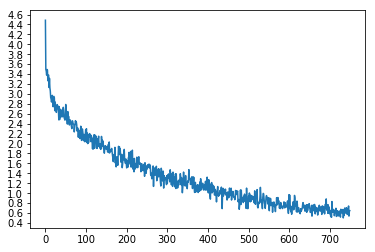

In [31]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [32]:
evaluateRandomly(encoder1, attn_decoder1)

> tu es agitee .
= you re restless .
< you re fabulous . <EOS>

> fais ce qu il te plait .
= you are welcome to do anything you like .
< you are looking forward to you you . <EOS>

> vous etes tout a fait attirant .
= you re quite attractive .
< you re quite attractive . <EOS>

> tu es a la fois mignon et gentil .
= you are both pretty and kind .
< you are both pretty and kind . <EOS>

> c est une fille mais elle est brave .
= she s a girl but she s brave .
< she s a real nice . she is <EOS>

> je suis heureux que tu aimes mes amis .
= i m glad you liked my friends .
< i am glad you liked my friends . <EOS>

> il n est pas idiot .
= he is no fool .
< he is not fool . <EOS>

> j ai faim !
= i m hungry .
< i m hungry ! <EOS>

> tu es libre de sortir .
= you are free to go out .
< you are free to go out . <EOS>

> je suis ami avec beaucoup d entre eux .
= i m friends with a lot of them .
< i m friends with a lot of . <EOS>



可视化注意力
---------------------

注意力机制的一个有用特性是其高度可解释的输出. 
由于它用于对输入序列的特定编码器输出进行加权,因此我们可以想象在每个时间步骤中查看网络最关注的位置.

您可以简单地运行 ``plt.matshow(attentions)``,将注意力输出显示为矩阵,
其中列是输入步骤,行是输出步骤.




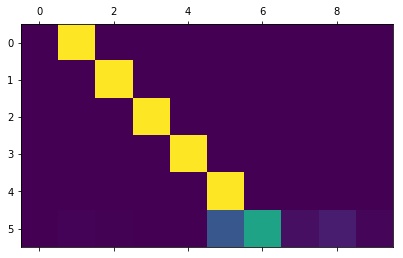

In [33]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())
plt.show()

为了获得更好的观看体验,我们将额外添加轴和标签:




input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>


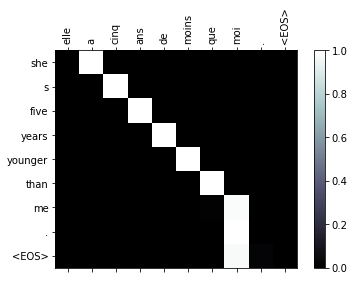

input = elle est trop petit .
output = she s too . <EOS>


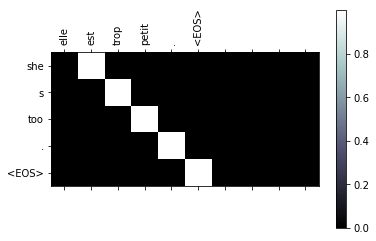

input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>


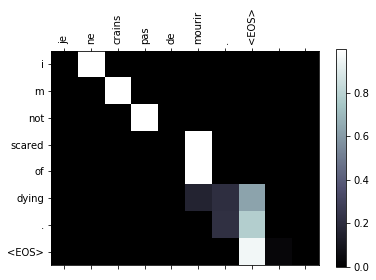

input = c est un jeune directeur plein de talent .
output = he s a promising young . <EOS>


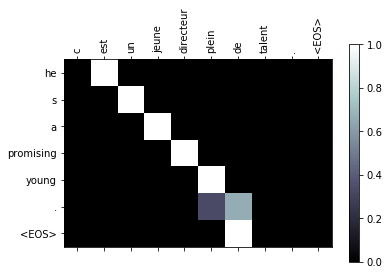

In [34]:
def showAttention(input_sentence, output_words, attentions):
    # 用颜色条设置图形
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 设置轴
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 在每个打勾处显示标签
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

part_random: ['j en suis content .', 'i m happy with that .']
input = j en suis content .
output = i m happy with that . <EOS>


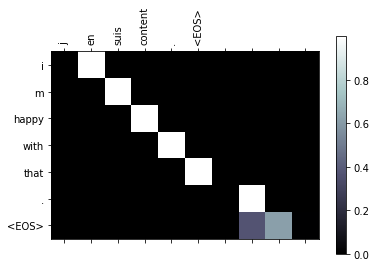

In [35]:
#随机挑选一个翻译对进行测试
part_random=random.choice(pairs)
print('part_random:',part_random)
evaluateAndShowAttention(part_random[0])

练习
=========

-  尝试使用不同的数据集

   -  另一种语言对
   -  人 → 机器 (例如. IOT 命令)
   -  聊天 → 响应
   -  问题 → 回答

-  用预先训练的词嵌入替换嵌入,例如word2vec或GloVe
-  尝试更多图层,更多隐藏单位和更多句子. 比较训练时间和结果.
-  如果您使用的翻译文件对中有两个相同的短语(``I am test \t I am test``),
   您可以使用它作为自动编码器.尝试这个:
   -  训练自编码器
   -  只保存编码器网络
   -  从那里训练一个新的解码器进行翻译


